# Exercises Hand-In 3 e1
## Group 30 (Oliver Nilsson)

In [5]:
# Import required libraries
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

# Print the versions of the libraries to check if they are installed correctly
print(f"Pandas version: {pd.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"NLTK version: {nltk.__version__}")
print(f"Re version: {re.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Pandas version: 1.5.3
Sklearn version: 1.4.2
NLTK version: 3.8.1
Re version: 2.2.1
Matplotlib version: 3.8.4


In [6]:
# Import csv file to a pandas dataframe
df_tweets = pd.read_csv('data/1377884570_tweet_global_warming.csv', encoding='ISO-8859-1', engine='python')
df_tweets.dropna(inplace=True)  # Drop rows with missing values

# Replace Yes/Y with 1 and No/N with 0
df_tweets['existence'] = df_tweets['existence'].map({'Y': 1, 'Yes': 1, 'N': 0, 'No': 0}).astype(int)

# Remove "[link]" from the tweets
df_tweets['tweet'] = df_tweets['tweet'].replace('\\[link\\]', '', regex=True)

# Display the first 5 rows of the dataframe
df_tweets.head()

,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,1,1.0000
1,Fighting poverty and global warming in Africa,1,1.0000
2,Carbon offsets: How a Vatican forest failed to...,1,0.8786
3,Carbon offsets: How a Vatican forest failed to...,1,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,1,0.8087


In [4]:
# Split the data randomly into a test and a training set (70/30 % of the observations)
# Using random_state as seed for reproducibility
train_df, test_df = train_test_split(df_tweets, test_size=0.3, random_state=42)

train_df.head()

,tweet,existence,existence.confidence
230,Ocean Saltiness Shows Global Warming Is Intens...,1,1.0000
498,RT @panteraonca07: Slideshow of Alaska Before ...,1,1.0000
2510,"@prismsinc Worlds Greenest Celebrity: Limos, P...",1,0.6499
5115,FRIDAY AFTERNOON IGNORANCE-OFF: Virginia GOP (...,1,0.6717
3370,RT @mmfa: Brain Freeze: Conservative media sti...,1,0.6969


## 1. Train a logistic lasso model to predict non-climate sceptic language

### a)

In [5]:
# Define required functions
def alpha_only(text):
    # Only keep alphabetic characters and spaces
    return re.sub("[^a-zA-Z\s]", "", text)

# Create a stemmer object
stemmer = SnowballStemmer("english")

def stem_tokens(tokens):
    # Stem the tokens using the Snowball stemmer
    return [stemmer.stem(token) for token in tokens]

def tokenize(text):
    # Tokenize the text and stem the tokens
    tokens = text.split()
    return stem_tokens(tokens)

# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(preprocessor=alpha_only, tokenizer=tokenize, stop_words='english')

# Convert the training and test set to a matrix of TF-IDF features
# Fit and transform the training set
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['tweet'])
# Transform is used to ensure that the test set is transformed using the same vectorizer as the training set
X_test_tfidf = tfidf_vectorizer.transform(test_df['tweet'])

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_38780/4007443454.py:4: SyntaxWarning: invalid escape sequence '\s'
  return re.sub("[^a-zA-Z\s]", "", text)
/anaconda/envs/h3e/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/anaconda/envs/h3e/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher'

In [6]:
# Inspect the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the first 5 feature names
print(feature_names)

['aap' 'aaronmorri' 'ab' ... 'ztf' 'zuniaorg' 'zyenab']


In [7]:
# Logistic Regression with Cross-Validation for Lasso (L1) Regularization
# Create a LogisticRegressionCV object
logistic_l1 = LogisticRegressionCV(Cs=2, cv=10, penalty='l1', solver='liblinear', random_state=42, max_iter=100)
logistic_l1.fit(X_train_tfidf, train_df['existence'])

LogisticRegressionCV(Cs=2, cv=10, penalty='l1', random_state=42,
                     solver='liblinear')

In [8]:
# Display the coefficients of the model
lasso_coef = pd.Series(logistic_l1.coef_[0], index=feature_names)
print(lasso_coef[lasso_coef != 0])

aaronmorri     4.626203
abat         -15.644215
abc           13.695760
abl            0.011088
abnorm         7.204301
                ...    
zealot         2.952347
zener          7.751056
zoeart        -3.266355
zoecaron       0.101842
zyenab        -5.698737
Length: 2002, dtype: float64


In [13]:
# Predict on test data
lasso_pred = logistic_l1.predict_proba(X_test_tfidf)[:, 1]

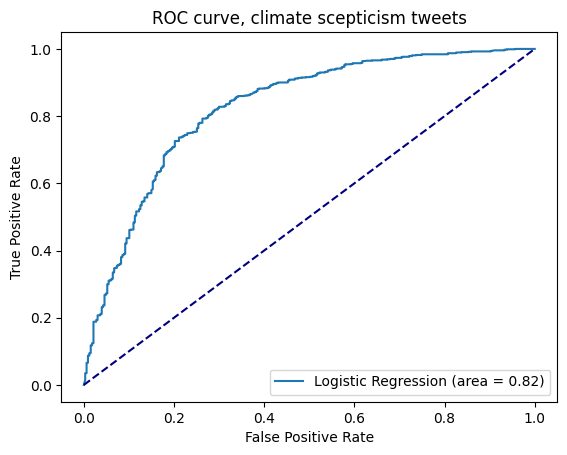

In [10]:
# ROC curve
fpr, tpr, thresholds = roc_curve(test_df['existence'], lasso_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(test_df['existence'], lasso_pred))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, climate scepticism tweets')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Compute AUC
auc = roc_auc_score(test_df['existence'], lasso_pred)
print(f"AUC: {auc}")

AUC: 0.8247878663793805


In [22]:
# Test the model with a new tweet
tweet = "Climat change is fake news"
# Transform the tweet to a matrix of TF-IDF features
tweet_tfidf = tfidf_vectorizer.transform([tweet])

# Predict the existence of climate scepticism in the tweet
tweet_pred = logistic_l1.predict_proba(tweet_tfidf)[:, 1]

# Determine the level of climate scepticism in the tweet
tweet_pred_level = 1 if tweet_pred[0] > 0.5 else 0

# Determine the conclusion of the prediction
tweet_pred_conclusion = "Tweet is sceptical about climate change" if tweet_pred_level == 1 else "Tweet is not sceptical about climate change"
print(tweet_pred_level)
print(f"Prediction: {tweet_pred[0]}\n{tweet_pred_conclusion}")

1
Prediction: 0.999999985775573
Tweet is sceptical about climate change
